In [1]:
# 인공신경망관련 패키지
from keras.callbacks import ModelCheckpoint
from keras.models import Sequential
from keras.layers import Dense, Activation, Flatten

# 회귀분석 관련 패키지
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error 
from xgboost import XGBRegressor

from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso
from scipy import stats

# OLS회귀분석
import statsmodels.api as sm

# 시각화 패키지
from matplotlib import pyplot as plt
import seaborn as sb

# 데이터 처리를 위한 패키지
import pandas as pd
import numpy as np
import math

# 다중공선성(multicollinearity) 처리를 위한VIF 확인 패키지
from statsmodels.stats.outliers_influence import variance_inflation_factor

import matplotlib
import matplotlib.pyplot as plt
# 한글 처리
from matplotlib import rc, font_manager
font_name = font_manager.FontProperties(fname='C:/Windows/Fonts/NanumGothicCoding.ttf').get_name()
rc('font',family=font_name)

# from matplotlib import rcParams
# rcParams['font.family'] = 'NanumGothicCoding'

# - 마이너스 사인 처리
matplotlib.rcParams['axes.unicode_minus'] = False

# DeprecationWarning경고 무시
# 향후 안쓰일 함수들을 이용해서 만들어져 있기 때문에 필요하다 없으면, 사방이 붉어진다.
import warnings 
warnings.filterwarnings('ignore')
warnings.filterwarnings('ignore', category=DeprecationWarning)

Using TensorFlow backend.
C:\Anaconda3\lib\site-packages\sklearn\ensemble\weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d


In [2]:
#########################################################################
# MAD 기반 예제코드
def mad_based_outlier(points, thresh=3.5):
    if len(points.shape) == 1:
        points = points[:,None]
    median = np.median(points, axis=0)
    diff = np.sum((points - median)**2, axis=-1)
    diff = np.sqrt(diff)
    med_abs_deviation = np.median(diff)
    modified_z_score = 0.6745 * diff / med_abs_deviation
    return modified_z_score > thresh 

# 출처: https://pythonanalysis.tistory.com/7 [Python 데이터 분석]
#########################################################################

# 소셜 데이터 처리를 위한 함수
# 1. 모든 소셜 데이터 column들의 첫번째는 : 날짜다.
# 2. 각 소셜데이터는 social_키워드.블로그/트위터/뉴스/총합 으로 되어 있다.
def changeColNames(d,before, after) : 
    # 컬럼이름 시리즈로 만들어 반환
    # 통합하기 쉽게, 모든 데이터들의 날짜컬럼 이름을 date로 통일
    new_col_names = ['date']
    new_col_names.extend(list(d.columns)[1:])
    d.columns = new_col_names
    return pd.Series(d.columns).apply(lambda x : x.replace(before,after))

#########################################################################
# modeling 함수로 만들어 처리하기
def linReg(df, item, cols_using):
    cols = cols_using
    X = df.loc[df['category']==item, cols]
    y = df.loc[df['category']==item,'qty']

    X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.3, random_state=0)

    model = LinearRegression().fit(X_train, y_train)
  
    print('LinearRegression을 이용한 %s의 회귀분석 결과 :'%item)
    print('훈련세트점수 : {:.2f}'.format(model.score(X_train, y_train)))
    print('검증세트점수 : {:.2f}'.format(model.score(X_test, y_test)))

    
def ridgeReg(df, item, cols_using):
    cols = cols_using
    X = df.loc[df['category']==item,cols]
    y = df.loc[df['category']==item,'qty']

    X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.3, random_state=0)

    ridge = Ridge(alpha=0.1, normalize=True, random_state=0, tol=0.001).fit(X_train, y_train)
    
    print('RidgeRegression을 이용한 %s의 회귀분석 결과 :'%item)
    print('훈련세트점수 : {:.2f}'.format(ridge.score(X_train, y_train)))
    print('검증세트점수 : {:.2f}'.format(ridge.score(X_test, y_test)))


def lassoReg(df, item, cols_using):
    cols = cols_using
    X = df.loc[df['category']==item,cols]
    y = df.loc[df['category']==item,'qty']

    X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.3, random_state=0)

    lasso = Lasso(alpha=0.1, max_iter=1000).fit(X=X_train, y=y_train)
  
    print('LassoRegression을 이용한 %s의 회귀분석 결과 :'%item)
    print('훈련세트점수 : {:.2f}'.format(lasso.score(X_train, y_train)) )
    print('검증세트점수 : {:.2f}'.format(lasso.score(X_test, y_test)) )

    #사용한 특성수
    print('사용한 특성수 : {}'.format(np.sum(lasso.coef_ != 0)) )
#########################################################################

# 자료가 1일 1행이라는 전제하에
# df길이를 이용하여 날짜수를 계산, 이후 2016년 1월1일을 1번째주 1일이라 기준하에
# 몇번째 주인지 알려주는 컬럼 추가. 향후 주단위로 종합할때 스인다.
def addDayWeek(df):
    df_work = df.copy()
    df_work['day'] = pd.Series(range(1,df_work.shape[0]+1)).astype('int64')
    df_work['week'] = df_work['day'].apply(lambda x : math.ceil(x/7))
    return df_work
#########################################################################
# 자료를 병합해주는 함수, 어떤 item인지 어느 컬럼을 기준으로 할지 받아서 병합
def mergeForAnalysis(df1, df2, df3, item, on_what='date'):
    merged_df = pd.merge(df1.loc[df1.category==item], df2, on=on_what, how='left')
    merged_df = pd.merge(merged_df, df3, on=on_what, how='left')
    return merged_df


#########################################################################
def lowVIF(df, n=7, cols_using =['temp', 'cloud', 'wind','humid', 'hpa', 'sun_time', 'lgt_time', 
       'SO2', 'CO', 'O3', 'NO2', 'PM10', 'PM25'] ):
    col_to_use = cols_using
    vif = pd.DataFrame()
    vif["VIF_Factor"] = [variance_inflation_factor(
        df[col_to_use].values, i) for i in range(df[col_to_use].shape[1])]
    vif["features"] = col_to_use
    vif.sort_values("VIF_Factor")
    lowest_vif = vif.sort_values("VIF_Factor")[:n].reset_index()
    lowest_vif.drop(columns='index', inplace=True)
    return lowest_vif

#########################################################################
# ols모델용 formula 생성
def formulaGen(target, ind_features):
    '''
    formulaGen(목표컬럼명,[변수컬럼명1, 변수컬럼명2,...])
    '''
    custom_formula = target + " ~ "
    for f in range(len(ind_features)):
        custom_formula += ind_features[f]
        if f!=(len(ind_features)-1):
            custom_formula += " + "
    return custom_formula
#########################################################################

In [3]:
# 데이터 불러오기 (전처리 된 GS, 랄라블라, 날씨)
gs = pd.read_csv('d:/project/contest/data/processed/p_gs.csv', parse_dates=['date'])
lv = pd.read_csv('d:/project/contest/data/processed/p_lavla.csv', parse_dates=['date'])
w = pd.read_csv('d:/project/contest/data/processed/p_wUVair_seoul_category.csv', parse_dates=['date'], index_col=0)
sns_all = pd.read_csv('d:/project/contest/data/processed/social_all.csv', parse_dates=['date'])

# GS/lv 서울시만
gs_seoul = gs.loc[gs.pvn_nm =='서울특별시']
lv_seoul = lv.loc[lv.pvn_nm =='서울특별시']
w_seoul = w.loc[w['loc']==108]

cols_to_keep = ['date','bor_nm','gender','age_cd','category','qty']

# 일일, 구단위, 상품별 판매량 종합
gs_grouped = gs_seoul[cols_to_keep].groupby(by=['date','bor_nm','category']).sum().reset_index()

# 일단위로 자료 종합(qty는 일일 합계)
day_gs_grouped = gs_grouped.groupby(by=['date','category']).sum().reset_index()

In [4]:
# '마스크'만 빼서 df생성
item = '마스크'
grouped_by = 'date'
day_gs_grouped_w_item = pd.merge(day_gs_grouped.loc[day_gs_grouped.category==item],w_seoul,on='date',how='left')
# day_gs_grouped_w_item.head(3)
day_gs_grouped_w_sns_item = pd.merge(day_gs_grouped_w_item, sns_all,on='date',how='left')

# 일단 uv = 자외선 지수는 결측치가 많아서 제외
selected_cols = ['date', 'category', 'qty', 'temp', 'rain', 'cloud', 'wind','humid', 'hpa',
                 'sun_time', 'lgt_time', 'snow','rain_or_not','snow_or_not',
                 'SO2', 'CO', 'O3', 'NO2', 'PM10', 'PM25',
                 'pm_blog', 'pm_twitter', 'pm_news', 'pm_total',
                 'health_blog', 'health_twitter', 'health_news', 'health_total',
                 'date_blog', 'date_twitter', 'date_news', 'date_total',
                 'br_blog', 'br_twitter', 'br_news', 'br_total',
                 'hobby_blog', 'hobby_twitter', 'hobby_news', 'hobby_total']
gs_day_w = day_gs_grouped_w_sns_item[selected_cols]

In [43]:
# MAD적용
gs_day_w['outlier'] = pd.DataFrame(mad_based_outlier(gs_day_w['qty']))
gs_day_w = gs_day_w.loc[gs_day_w.outlier==False]

In [44]:
list_col = ['temp', 'cloud', 'wind', 'lgt_time', 'PM10'] # +,'rain_or_not','snow_or_not'
lowVIF(w,40,list_col)

,VIF_Factor,features
0,3.715302,temp
1,4.682044,PM10
2,6.314379,cloud
3,7.886587,lgt_time
4,8.692697,wind


In [45]:
train_data = gs_day_w.loc[gs_day_w.date.between('2016-01-01','2017-12-31')]
test_data = gs_day_w.loc[gs_day_w.date.between('2018-01-01','2018-12-31')]

# 3년치 데이터 분리 : 종속변수('qty': 판매량)와 독립변수(판매량 제외 나머지 전부)
# 날씨 데이터만, 
# 'temp', 'rain', 'cloud', 'wind','humid', 'hpa',
# 'sun_time', 'lgt_time', 'snow','rain_or_not','snow_or_not',
# 'SO2', 'CO', 'O3', 'NO2', 'PM10', 'PM25',
combined = gs_day_w.loc[:,list_col+['rain_or_not','snow_or_not']]
target = gs_day_w.loc[:,'qty']

In [46]:
combined.head(2)

,temp,cloud,wind,lgt_time,PM10,rain_or_not,snow_or_not
0,1.2,7.0,1.6,2.1,68.696500,비x,눈x
1,5.7,7.8,2.0,3.6,53.618667,비x,눈x


In [47]:
Xy = pd.concat([target,combined], axis=1)

In [48]:
def get_cols_with_no_nans(df,col_type):
    '''
    Arguments :
    df : The dataframe to process
    col_type : 
          num : to only get numerical columns with no nans
          no_num : to only get nun-numerical columns with no nans
          all : to get any columns with no nans    
    '''
    if (col_type == 'num'):
        predictors = df.select_dtypes(exclude=['object'])
    elif (col_type == 'no_num'):
        predictors = df.select_dtypes(include=['object'])
    elif (col_type == 'all'):
        predictors = df
    else :
        print('Error : choose a type (num, no_num, all)')
        return 0
    cols_with_no_nans = []
    for col in predictors.columns:
        if not df[col].isnull().any():
            cols_with_no_nans.append(col)
    return cols_with_no_nans

In [49]:
num_cols = get_cols_with_no_nans(combined , 'num')
cat_cols = get_cols_with_no_nans(combined , 'no_num')

print ('수치형 자료 컬럼 갯수 :',len(num_cols))
print ('오브젝트형 자료 컬럼 갯수 :',len(cat_cols))

수치형 자료 컬럼 갯수 : 5
오브젝트형 자료 컬럼 갯수 : 2


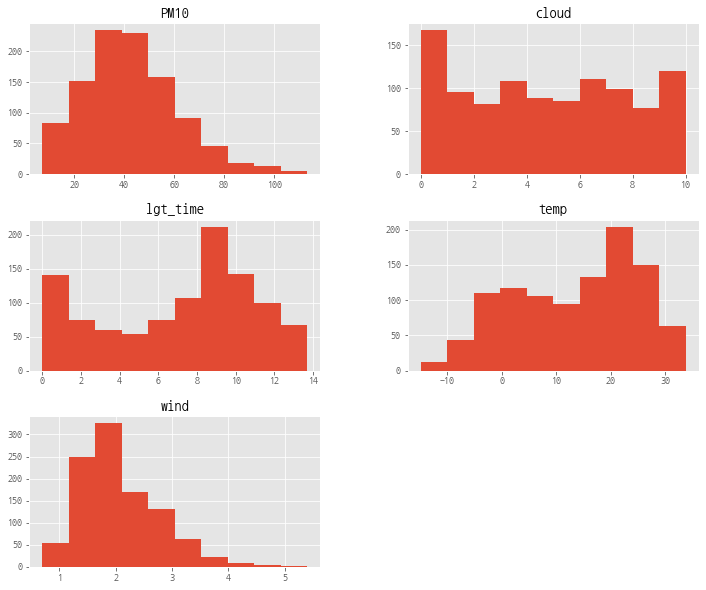

In [50]:
combined = combined[num_cols + cat_cols]
combined.hist(figsize = (12,10))
plt.show()

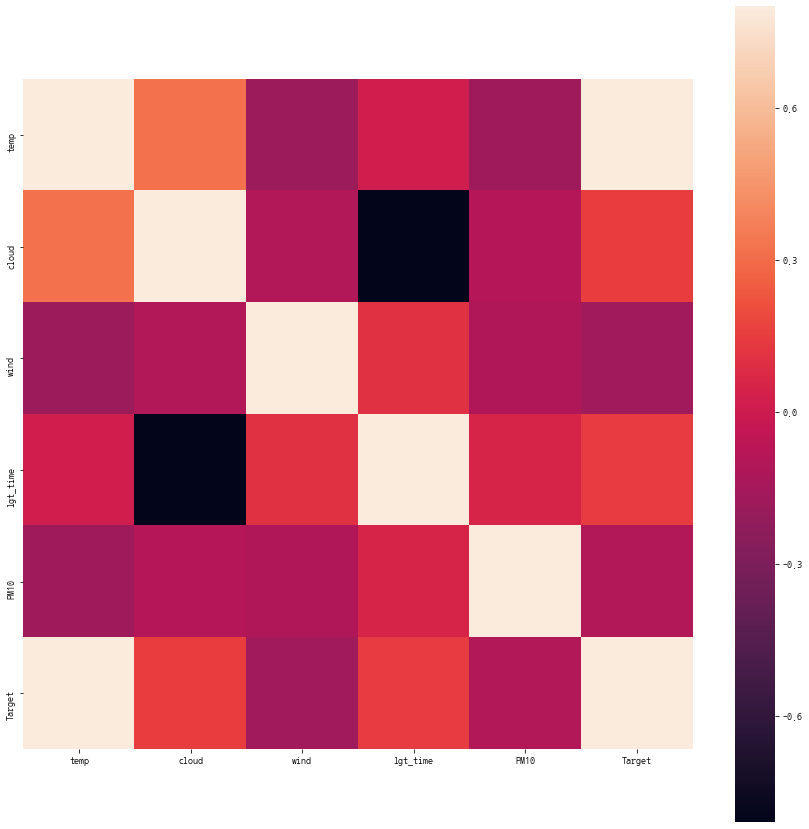

In [15]:
train_data = train_data[num_cols + cat_cols]
train_data['Target'] = target

C_mat = train_data.corr()
fig = plt.figure(figsize = (15,15))

sb.heatmap(C_mat, vmax = .8, square = True)
plt.show()

In [51]:
def oneHotEncode(df,colNames):
    for col in colNames:
        # 해당 컬럼의 데이터 타입이 object란 소리는 숫자가 아니다 = 분류형 데이터
        if( df[col].dtype == np.dtype('object')):
            # 더미 컬럼 생성
            dummies = pd.get_dummies(df[col],prefix=col)
            # 원본 데이터에 이어 붙이기 axis=1 컬럼방향으로 
            df = pd.concat([df,dummies],axis=1)

            # 기존의 str형 컬럼 삭제
            df.drop([col],axis = 1 , inplace=True)
    return df
    

print('분류형(category형) 컬럼 수정 전, 총 {} 개의 columns이 있었습니다.'.format(combined.shape[1]))
combined = oneHotEncode(combined, cat_cols)
print('분류형(category형) 컬럼 수정 후, 총 {} 개의 columns이 있었습니다.'.format(combined.shape[1]))

분류형(category형) 컬럼 수정 전, 총 7 개의 columns이 있었습니다.
분류형(category형) 컬럼 수정 후, 총 9 개의 columns이 있었습니다.


In [52]:
# 비o,비x는 하나가 1이면 다른하나는 0은 완저히 베타적인 관계이므로 한개를 삭제
# 눈o눈x,도 비와 같다.
combined.drop(['rain_or_not_비x'],axis = 1 , inplace=True)
combined.drop(['snow_or_not_눈x'],axis = 1 , inplace=True)
combined.head(1)

,temp,cloud,wind,lgt_time,PM10,rain_or_not_비o,snow_or_not_눈o
0,1.2,7.0,1.6,2.1,68.6965,0,0


In [53]:
combined.columns = ['temp', 'cloud', 'wind', 'lgt_time', 'PM10', 'rain_or_not_o',
       'snow_or_not_o']

In [54]:
Xy = pd.concat([target,combined], axis=1)
Xy.head(1)

,qty,temp,cloud,wind,lgt_time,PM10,rain_or_not_o,snow_or_not_o
0,266,1.2,7.0,1.6,2.1,68.6965,0,0


In [56]:
(combined.shape[0] * 2)//3

687

In [57]:
# (combined.shape[0] * 2)//3 첫 2/3 : 687
cut_line = (combined.shape[0] * 2)//3
def split_combined():
    global combined
    train = combined[:cut_line]
    test = combined[cut_line:]

    return train , test 
  
train, test = split_combined()

train.shape

(687, 7)

In [58]:
# 신경망 모델 생성
NN_model = Sequential()

# The Input Layer :
NN_model.add(Dense(128, kernel_initializer='normal',input_dim = train.shape[1], activation='relu'))

# The Hidden Layers :
NN_model.add(Dense(256, kernel_initializer='normal',activation='relu'))
NN_model.add(Dense(256, kernel_initializer='normal',activation='relu'))
NN_model.add(Dense(256, kernel_initializer='normal',activation='relu'))

# The Output Layer :
NN_model.add(Dense(1, kernel_initializer='normal',activation='linear'))

# Compile the network :
# optimizer에 여러 방식이 있다.
NN_model.compile(loss='mean_absolute_error', optimizer='adam', metrics=['mean_absolute_error'])
NN_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_6 (Dense)              (None, 128)               1024      
_________________________________________________________________
dense_7 (Dense)              (None, 256)               33024     
_________________________________________________________________
dense_8 (Dense)              (None, 256)               65792     
_________________________________________________________________
dense_9 (Dense)              (None, 256)               65792     
_________________________________________________________________
dense_10 (Dense)             (None, 1)                 257       
Total params: 165,889
Trainable params: 165,889
Non-trainable params: 0
_________________________________________________________________


In [59]:
# 인공 신경망에 의해 생성된 weight 자료를 저장하기 위해서
checkpoint_name = 'GS-mad적용'+item+grouped_by+'-Weights-{epoch:03d}--{val_loss:.5f}-cat02-vf05.hdf5' 

# save_best_only값이 저장되어, 모든 weight값을 저장하지 않고, val_loss값이 줄어들때마다(적을수록 좋다.) 저장
checkpoint = ModelCheckpoint(checkpoint_name, monitor='val_loss', verbose = 1, save_best_only = True, mode ='auto')
callbacks_list = [checkpoint]

In [60]:
checkpoint_name

'GS-mad적용마스크date-Weights-{epoch:03d}--{val_loss:.5f}-cat02-vf05.hdf5'

In [61]:
# 예제에서는 target을 대회에서 주는 target데이터를 기준으로 미리 train데이터와 맞춰졌있지만
# gs/lv데이터는 아니다. 그래서 위에서 나누는 기준으로 삼은cut_line=732을 이용하여 데이터 사이즈를 맞춰준다.
# 아니면 애시당초에(맨처음에) 훈련용 데이터와 타겟을 만들어 놓는것도 좋다.
NN_model.fit(train, target[:cut_line], epochs=500, batch_size=32, validation_split = 0.2, callbacks=callbacks_list)

Train on 549 samples, validate on 138 samples
Epoch 1/500
549/549 [==============================] - 0s 632us/step - loss: 324.9247 - mean_absolute_error: 324.9247 - val_loss: 219.6005 - val_mean_absolute_error: 219.6005

Epoch 00001: val_loss improved from inf to 219.60052, saving model to GS-mad적용마스크date-Weights-001--219.60052-cat02-vf05.hdf5
Epoch 2/500
549/549 [==============================] - 0s 87us/step - loss: 174.5848 - mean_absolute_error: 174.5848 - val_loss: 161.0678 - val_mean_absolute_error: 161.0678

Epoch 00002: val_loss improved from 219.60052 to 161.06776, saving model to GS-mad적용마스크date-Weights-002--161.06776-cat02-vf05.hdf5
Epoch 3/500
549/549 [==============================] - 0s 84us/step - loss: 150.3362 - mean_absolute_error: 150.3362 - val_loss: 151.5492 - val_mean_absolute_error: 151.5492

Epoch 00003: val_loss improved from 161.06776 to 151.54916, saving model to GS-mad적용마스크date-Weights-003--151.54916-cat02-vf05.hdf5
Epoch 4/500
549/549 [====================

549/549 [==============================] - 0s 91us/step - loss: 120.1805 - mean_absolute_error: 120.1805 - val_loss: 127.3941 - val_mean_absolute_error: 127.3941

Epoch 00033: val_loss did not improve from 99.15612
Epoch 34/500
549/549 [==============================] - 0s 80us/step - loss: 121.1873 - mean_absolute_error: 121.1873 - val_loss: 141.8023 - val_mean_absolute_error: 141.8023

Epoch 00034: val_loss did not improve from 99.15612
Epoch 35/500
549/549 [==============================] - ETA: 0s - loss: 123.2555 - mean_absolute_error: 123.255 - 0s 82us/step - loss: 125.8193 - mean_absolute_error: 125.8193 - val_loss: 158.8762 - val_mean_absolute_error: 158.8762

Epoch 00035: val_loss did not improve from 99.15612
Epoch 36/500
549/549 [==============================] - 0s 84us/step - loss: 124.4873 - mean_absolute_error: 124.4873 - val_loss: 116.8525 - val_mean_absolute_error: 116.8525

Epoch 00036: val_loss did not improve from 99.15612
Epoch 37/500
549/549 [=====================


Epoch 00068: val_loss did not improve from 99.15612
Epoch 69/500
549/549 [==============================] - 0s 78us/step - loss: 116.1744 - mean_absolute_error: 116.1744 - val_loss: 122.5253 - val_mean_absolute_error: 122.5253

Epoch 00069: val_loss did not improve from 99.15612
Epoch 70/500
549/549 [==============================] - ETA: 0s - loss: 145.4629 - mean_absolute_error: 145.462 - 0s 86us/step - loss: 114.1227 - mean_absolute_error: 114.1227 - val_loss: 112.5300 - val_mean_absolute_error: 112.5300

Epoch 00070: val_loss did not improve from 99.15612
Epoch 71/500
549/549 [==============================] - 0s 80us/step - loss: 119.1558 - mean_absolute_error: 119.1558 - val_loss: 111.3177 - val_mean_absolute_error: 111.3177

Epoch 00071: val_loss did not improve from 99.15612
Epoch 72/500
549/549 [==============================] - 0s 78us/step - loss: 113.3745 - mean_absolute_error: 113.3745 - val_loss: 130.5307 - val_mean_absolute_error: 130.5307

Epoch 00072: val_loss did not

549/549 [==============================] - 0s 84us/step - loss: 109.3595 - mean_absolute_error: 109.3595 - val_loss: 111.7393 - val_mean_absolute_error: 111.7393

Epoch 00104: val_loss did not improve from 99.15409
Epoch 105/500
549/549 [==============================] - 0s 82us/step - loss: 110.5933 - mean_absolute_error: 110.5933 - val_loss: 134.7081 - val_mean_absolute_error: 134.7081

Epoch 00105: val_loss did not improve from 99.15409
Epoch 106/500
549/549 [==============================] - 0s 87us/step - loss: 114.0032 - mean_absolute_error: 114.0032 - val_loss: 118.8510 - val_mean_absolute_error: 118.8510

Epoch 00106: val_loss did not improve from 99.15409
Epoch 107/500
549/549 [==============================] - 0s 98us/step - loss: 109.9062 - mean_absolute_error: 109.9062 - val_loss: 105.0775 - val_mean_absolute_error: 105.0775

Epoch 00107: val_loss did not improve from 99.15409
Epoch 108/500
549/549 [==============================] - 0s 84us/step - loss: 112.2681 - mean_abso


Epoch 00139: val_loss did not improve from 99.15409
Epoch 140/500
549/549 [==============================] - 0s 87us/step - loss: 107.8216 - mean_absolute_error: 107.8216 - val_loss: 117.0780 - val_mean_absolute_error: 117.0780

Epoch 00140: val_loss did not improve from 99.15409
Epoch 141/500
549/549 [==============================] - 0s 82us/step - loss: 108.5203 - mean_absolute_error: 108.5203 - val_loss: 124.4156 - val_mean_absolute_error: 124.4156

Epoch 00141: val_loss did not improve from 99.15409
Epoch 142/500
549/549 [==============================] - 0s 84us/step - loss: 109.8969 - mean_absolute_error: 109.8969 - val_loss: 131.7935 - val_mean_absolute_error: 131.7935

Epoch 00142: val_loss did not improve from 99.15409
Epoch 143/500
549/549 [==============================] - 0s 84us/step - loss: 107.9022 - mean_absolute_error: 107.9022 - val_loss: 124.0298 - val_mean_absolute_error: 124.0298

Epoch 00143: val_loss did not improve from 99.15409
Epoch 144/500
549/549 [========

549/549 [==============================] - 0s 89us/step - loss: 108.4215 - mean_absolute_error: 108.4215 - val_loss: 116.5325 - val_mean_absolute_error: 116.5325

Epoch 00175: val_loss did not improve from 99.15409
Epoch 176/500
549/549 [==============================] - 0s 78us/step - loss: 110.7942 - mean_absolute_error: 110.7942 - val_loss: 113.6769 - val_mean_absolute_error: 113.6769

Epoch 00176: val_loss did not improve from 99.15409
Epoch 177/500
549/549 [==============================] - 0s 80us/step - loss: 106.3778 - mean_absolute_error: 106.3778 - val_loss: 113.7364 - val_mean_absolute_error: 113.7364

Epoch 00177: val_loss did not improve from 99.15409
Epoch 178/500
549/549 [==============================] - 0s 83us/step - loss: 105.5573 - mean_absolute_error: 105.5573 - val_loss: 136.5377 - val_mean_absolute_error: 136.5377

Epoch 00178: val_loss did not improve from 99.15409
Epoch 179/500
549/549 [==============================] - 0s 84us/step - loss: 106.4508 - mean_abso

549/549 [==============================] - 0s 89us/step - loss: 107.6117 - mean_absolute_error: 107.6117 - val_loss: 110.6212 - val_mean_absolute_error: 110.6212

Epoch 00211: val_loss did not improve from 99.15409
Epoch 212/500
549/549 [==============================] - 0s 85us/step - loss: 113.8550 - mean_absolute_error: 113.8550 - val_loss: 106.4901 - val_mean_absolute_error: 106.4901

Epoch 00212: val_loss did not improve from 99.15409
Epoch 213/500
549/549 [==============================] - 0s 89us/step - loss: 107.8991 - mean_absolute_error: 107.8991 - val_loss: 100.6759 - val_mean_absolute_error: 100.6759

Epoch 00213: val_loss did not improve from 99.15409
Epoch 214/500
549/549 [==============================] - 0s 80us/step - loss: 109.0437 - mean_absolute_error: 109.0437 - val_loss: 105.9222 - val_mean_absolute_error: 105.9222

Epoch 00214: val_loss did not improve from 99.15409
Epoch 215/500
549/549 [==============================] - 0s 85us/step - loss: 113.6447 - mean_abso


Epoch 00246: val_loss did not improve from 99.08407
Epoch 247/500
549/549 [==============================] - 0s 100us/step - loss: 104.5236 - mean_absolute_error: 104.5236 - val_loss: 115.9573 - val_mean_absolute_error: 115.9573

Epoch 00247: val_loss did not improve from 99.08407
Epoch 248/500
549/549 [==============================] - 0s 131us/step - loss: 103.6001 - mean_absolute_error: 103.6001 - val_loss: 125.2332 - val_mean_absolute_error: 125.2332

Epoch 00248: val_loss did not improve from 99.08407
Epoch 249/500
549/549 [==============================] - 0s 98us/step - loss: 109.9420 - mean_absolute_error: 109.9420 - val_loss: 127.4065 - val_mean_absolute_error: 127.4065

Epoch 00249: val_loss did not improve from 99.08407
Epoch 250/500
549/549 [==============================] - 0s 89us/step - loss: 104.7821 - mean_absolute_error: 104.7821 - val_loss: 117.4475 - val_mean_absolute_error: 117.4475

Epoch 00250: val_loss did not improve from 99.08407
Epoch 251/500
549/549 [======


Epoch 00282: val_loss did not improve from 99.08407
Epoch 283/500
549/549 [==============================] - 0s 104us/step - loss: 109.2831 - mean_absolute_error: 109.2831 - val_loss: 94.4948 - val_mean_absolute_error: 94.4948

Epoch 00283: val_loss improved from 99.08407 to 94.49476, saving model to GS-mad적용마스크date-Weights-283--94.49476-cat02-vf05.hdf5
Epoch 284/500
549/549 [==============================] - 0s 89us/step - loss: 109.1213 - mean_absolute_error: 109.1213 - val_loss: 111.0509 - val_mean_absolute_error: 111.0509

Epoch 00284: val_loss did not improve from 94.49476
Epoch 285/500
549/549 [==============================] - 0s 94us/step - loss: 107.4850 - mean_absolute_error: 107.4850 - val_loss: 119.3360 - val_mean_absolute_error: 119.3360

Epoch 00285: val_loss did not improve from 94.49476
Epoch 286/500
549/549 [==============================] - 0s 98us/step - loss: 104.8458 - mean_absolute_error: 104.8458 - val_loss: 110.0876 - val_mean_absolute_error: 110.0876

Epoch 00

549/549 [==============================] - 0s 100us/step - loss: 104.6204 - mean_absolute_error: 104.6204 - val_loss: 121.1894 - val_mean_absolute_error: 121.1894

Epoch 00318: val_loss did not improve from 94.49476
Epoch 319/500
549/549 [==============================] - 0s 98us/step - loss: 101.6675 - mean_absolute_error: 101.6675 - val_loss: 114.7990 - val_mean_absolute_error: 114.7990

Epoch 00319: val_loss did not improve from 94.49476
Epoch 320/500
549/549 [==============================] - 0s 96us/step - loss: 100.4445 - mean_absolute_error: 100.4445 - val_loss: 113.7410 - val_mean_absolute_error: 113.7410

Epoch 00320: val_loss did not improve from 94.49476
Epoch 321/500
549/549 [==============================] - 0s 100us/step - loss: 103.2478 - mean_absolute_error: 103.2478 - val_loss: 120.1767 - val_mean_absolute_error: 120.1767

Epoch 00321: val_loss did not improve from 94.49476
Epoch 322/500
549/549 [==============================] - 0s 105us/step - loss: 102.2749 - mean_a


Epoch 00353: val_loss did not improve from 94.49476
Epoch 354/500
549/549 [==============================] - 0s 136us/step - loss: 97.0884 - mean_absolute_error: 97.0884 - val_loss: 123.4664 - val_mean_absolute_error: 123.4664

Epoch 00354: val_loss did not improve from 94.49476
Epoch 355/500
549/549 [==============================] - 0s 127us/step - loss: 99.1831 - mean_absolute_error: 99.1831 - val_loss: 113.4555 - val_mean_absolute_error: 113.4555

Epoch 00355: val_loss did not improve from 94.49476
Epoch 356/500
549/549 [==============================] - 0s 120us/step - loss: 100.8413 - mean_absolute_error: 100.8413 - val_loss: 112.8246 - val_mean_absolute_error: 112.8246

Epoch 00356: val_loss did not improve from 94.49476
Epoch 357/500
549/549 [==============================] - 0s 134us/step - loss: 99.2328 - mean_absolute_error: 99.2328 - val_loss: 115.8220 - val_mean_absolute_error: 115.8220

Epoch 00357: val_loss did not improve from 94.49476
Epoch 358/500
549/549 [==========


Epoch 00389: val_loss did not improve from 94.49476
Epoch 390/500
549/549 [==============================] - 0s 120us/step - loss: 95.5284 - mean_absolute_error: 95.5284 - val_loss: 122.7529 - val_mean_absolute_error: 122.7529

Epoch 00390: val_loss did not improve from 94.49476
Epoch 391/500
549/549 [==============================] - 0s 120us/step - loss: 98.4301 - mean_absolute_error: 98.4301 - val_loss: 134.3264 - val_mean_absolute_error: 134.3264

Epoch 00391: val_loss did not improve from 94.49476
Epoch 392/500
549/549 [==============================] - 0s 140us/step - loss: 105.3379 - mean_absolute_error: 105.3379 - val_loss: 129.8738 - val_mean_absolute_error: 129.8738

Epoch 00392: val_loss did not improve from 94.49476
Epoch 393/500
549/549 [==============================] - 0s 129us/step - loss: 97.6558 - mean_absolute_error: 97.6558 - val_loss: 115.9960 - val_mean_absolute_error: 115.9960

Epoch 00393: val_loss did not improve from 94.49476
Epoch 394/500
549/549 [==========


Epoch 00425: val_loss did not improve from 94.49476
Epoch 426/500
549/549 [==============================] - 0s 129us/step - loss: 92.1343 - mean_absolute_error: 92.1343 - val_loss: 117.1462 - val_mean_absolute_error: 117.1462

Epoch 00426: val_loss did not improve from 94.49476
Epoch 427/500
549/549 [==============================] - 0s 124us/step - loss: 91.9291 - mean_absolute_error: 91.9291 - val_loss: 123.0192 - val_mean_absolute_error: 123.0192

Epoch 00427: val_loss did not improve from 94.49476
Epoch 428/500
549/549 [==============================] - 0s 143us/step - loss: 91.6228 - mean_absolute_error: 91.6228 - val_loss: 113.5496 - val_mean_absolute_error: 113.5496

Epoch 00428: val_loss did not improve from 94.49476
Epoch 429/500
549/549 [==============================] - 0s 129us/step - loss: 93.1998 - mean_absolute_error: 93.1998 - val_loss: 118.3287 - val_mean_absolute_error: 118.3287

Epoch 00429: val_loss did not improve from 94.49476
Epoch 430/500
549/549 [============


Epoch 00461: val_loss did not improve from 94.49476
Epoch 462/500
549/549 [==============================] - 0s 142us/step - loss: 91.8048 - mean_absolute_error: 91.8048 - val_loss: 112.8999 - val_mean_absolute_error: 112.8999

Epoch 00462: val_loss did not improve from 94.49476
Epoch 463/500
549/549 [==============================] - ETA: 0s - loss: 91.6556 - mean_absolute_error: 91.6556  - 0s 141us/step - loss: 88.1014 - mean_absolute_error: 88.1014 - val_loss: 121.7247 - val_mean_absolute_error: 121.7247

Epoch 00463: val_loss did not improve from 94.49476
Epoch 464/500
549/549 [==============================] - 0s 138us/step - loss: 87.4521 - mean_absolute_error: 87.4521 - val_loss: 114.4309 - val_mean_absolute_error: 114.4309

Epoch 00464: val_loss did not improve from 94.49476
Epoch 465/500
549/549 [==============================] - 0s 143us/step - loss: 87.5584 - mean_absolute_error: 87.5584 - val_loss: 114.5339 - val_mean_absolute_error: 114.5339

Epoch 00465: val_loss did not

549/549 [==============================] - 0s 183us/step - loss: 84.7427 - mean_absolute_error: 84.7427 - val_loss: 114.8542 - val_mean_absolute_error: 114.8542

Epoch 00497: val_loss did not improve from 94.49476
Epoch 498/500
549/549 [==============================] - 0s 182us/step - loss: 82.8148 - mean_absolute_error: 82.8148 - val_loss: 120.2278 - val_mean_absolute_error: 120.2278

Epoch 00498: val_loss did not improve from 94.49476
Epoch 499/500
549/549 [==============================] - 0s 151us/step - loss: 83.5108 - mean_absolute_error: 83.5108 - val_loss: 125.7256 - val_mean_absolute_error: 125.7256

Epoch 00499: val_loss did not improve from 94.49476
Epoch 500/500
549/549 [==============================] - 0s 200us/step - loss: 89.7529 - mean_absolute_error: 89.7529 - val_loss: 126.6001 - val_mean_absolute_error: 126.6001

Epoch 00500: val_loss did not improve from 94.49476


In [62]:
# 500번을 학습하여 나온 결과들중, 가장 좋은(마지막에 저장된) Weights파일을 가져온다.
# Load wights file of the best model :
# 파일은 이 코드랑 같은 폴더에 위치해있어야 작동
wights_file = 'GS-mad적용마스크date-Weights-283--94.49476-cat02-vf05.hdf5' # choose the best checkpoint 
NN_model.load_weights(wights_file) # load it
NN_model.compile(loss='mean_absolute_error', optimizer='adam', metrics=['mean_absolute_error'])

In [63]:
#2016~2018전체를 난수로 0.67:0.33 = 2:1
# train3 = combined.loc[:,'temp':]
# target3 = combined.loc[:,'qty']
# train_X, val_X, train_y, val_y = train_test_split(train3, target3, test_size = 0.33, random_state = 14)

# 2016~2017 : 훈련 / 2018 검증 2:1
# 1~732 / 732~1096
trainXy = Xy[:cut_line]
testXy = Xy[cut_line:]

# 독립변수들
train_X = trainXy.loc[:,'temp':]
# 정답(판매량)
train_y = trainXy.loc[:,'qty']

val_X = testXy.loc[:,'temp':]
val_y = testXy.loc[:,'qty']



print('여기서 점수란 R-square값을 의미한다.')
# RandomForest 회귀분석
RFmodel = RandomForestRegressor()
RFmodel.fit(train_X,train_y)
# Get the mean absolute error on the validation data
RFpredicted = RFmodel.predict(val_X)
MAE = mean_absolute_error(val_y , RFpredicted)
print('Random forest을 이용한 %s의 회귀분석 결과 :'%item)
# print('Random forest validation MAE = ', MAE)
print('훈련세트점수 : {:.3f}'.format(RFmodel.score(train_X, train_y)))
print('검증세트점수 : {:.3f}'.format(RFmodel.score(val_X, val_y)))

# XGBRegressor 회귀분석
XGBModel = XGBRegressor(objective='reg:squarederror')
XGBModel.fit(train_X,train_y , verbose=False)
# Get the mean absolute error on the validation data :
XGBpredictions = XGBModel.predict(val_X)
MAE = mean_absolute_error(val_y , XGBpredictions)
print('XGBoost을 이용한 %s의 회귀분석 결과 :'%item)
# print('XGBoost validation MAE = ',MAE)
print('훈련세트점수 : {:.3f}'.format(XGBModel.score(train_X, train_y)))
print('검증세트점수 : {:.3f}'.format(XGBModel.score(val_X, val_y)))

linReg = LinearRegression().fit(train_X, train_y)
print('LinearRegression을 이용한 %s의 회귀분석 결과 :'%item)
print('훈련세트점수 : {:.3f}'.format(linReg.score(train_X, train_y)))
print('검증세트점수 : {:.3f}'.format(linReg.score(val_X, val_y)))

ridge = Ridge(alpha=0.1, normalize=True, random_state=0, tol=0.001).fit(train_X, train_y)
print('RidgeRegression을 이용한 %s의 회귀분석 결과 :'%item)
print('훈련세트점수 : {:.3f}'.format(ridge.score(train_X, train_y)))
print('검증세트점수 : {:.3f}'.format(ridge.score(val_X, val_y)))

lasso = Lasso(alpha=0.1, max_iter=1000).fit(train_X, train_y)
print('LassoRegression을 이용한 %s의 회귀분석 결과 :'%item)
print('훈련세트점수 : {:.3f}'.format(lasso.score(train_X, train_y)) )
print('검증세트점수 : {:.3f}'.format(lasso.score(val_X, val_y)) )

customF = formulaGen(target='qty',ind_features=list_col)
olsModel = sm.OLS.from_formula(customF, data=trainXy).fit()
print('OLS을 이용한 %s의 회귀분석 결과 :'%item)
print('훈련세트점수 : {:.3f}'.format(olsModel.rsquared) )

여기서 점수란 R-square값을 의미한다.
Random forest을 이용한 마스크의 회귀분석 결과 :
훈련세트점수 : 0.897
검증세트점수 : 0.491
XGBoost을 이용한 마스크의 회귀분석 결과 :
훈련세트점수 : 0.725
검증세트점수 : 0.491
LinearRegression을 이용한 마스크의 회귀분석 결과 :
훈련세트점수 : 0.388
검증세트점수 : 0.367
RidgeRegression을 이용한 마스크의 회귀분석 결과 :
훈련세트점수 : 0.385
검증세트점수 : 0.353
LassoRegression을 이용한 마스크의 회귀분석 결과 :
훈련세트점수 : 0.388
검증세트점수 : 0.367
OLS을 이용한 마스크의 회귀분석 결과 :
훈련세트점수 : 0.388


In [64]:
print(item, 'ols model')
# ind_features = 넣고 싶은 독립변수를 리스트로 넣어주면 알아서 formula생성해 준다.
# customF = formulaGen(target='qty',ind_features=['temp'])
# print(customF) qty ~ temp
# customF = formulaGen(target='qty',ind_features=['temp','cloud'])
# print(customF) # qty ~ temp + cloud
list_col = ['temp', 'lgt_time', 'PM10', 'snow_or_not_o', 'rain_or_not_o']

customF = formulaGen(target='qty',ind_features=list_col)
olsModel = sm.OLS.from_formula(customF, data=trainXy).fit()
olsModel.summary()

마스크 ols model


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                    qty   R-squared:                       0.385
Model:                            OLS   Adj. R-squared:                  0.380
Method:                 Least Squares   F-statistic:                     85.13
Date:                Fri, 19 Jul 2019   Prob (F-statistic):           1.83e-69
Time:                        12:23:43   Log-Likelihood:                -4501.8
No. Observations:                 687   AIC:                             9016.
Df Residuals:                     681   BIC:                             9043.
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
Intercept       265.0451     27.343      9.693      0.000     211.358     318.733
temp             -8.7081      0.633    -13.749      0.000      -9.952      -7.464
lgt_time          2.6783      1.991      1.345      0.179      -1.231       6.588
PM10              4.1303      0.368     11.222      0.000       3.408       4.853
snow_or_not_o    -6.4665     42.812     -0.151      0.880     -90.526      77.592
rain_or_not_o     7.0963     18.037      0.393      0.694     -28.318      42.511
==============================================================================
Omnibus:                       99.947   Durbin-Watson:                   0.667
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              172.793
Skew:                           0.901   Prob(JB):                     3.01e-38
Kurtosis:                       4.671   Cond. No.                         339.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [66]:
col_list = ['temp', 'cloud', 'wind', 'lgt_time', 'PM10', 'rain_or_not_o', 'snow_or_not_o']
combined = Xy.loc[:,'temp':]
target = Xy.loc[:,'qty']

# 가장 좋다고 판명된 설정을 이용하여, 예측qty생산
predictions = NN_model.predict(combined)
# RandomForest 회귀분석 예측 qty생산
RFpredicted = RFmodel.predict(combined)
# XGBRegressor 회귀분석 예측 qty생산
XGBpredictions = XGBModel.predict(combined)
# linearRegression 회귀분석 예측 qty생산
linPred = linReg.predict(combined)
# Ridge 회귀분석 예측 qty생산
ridPred = ridge.predict(combined)
# Lasso 회귀분석 예측 qty생산
lassoPred = lasso.predict(combined)
# OLS 회귀분석 예측 qty생산
olsPred = olsModel.predict(combined)

result_df = pd.DataFrame()
result_df['date'] = gs_day_w['date']
result_df['qty'] = Xy.loc[:,'qty']

# print("keras 신경망 predictions",predictions.shape)
result_df['keras_qty'] = predictions

# print("randomforest 예상",RFpredicted.shape)
result_df['rf_qty'] = RFpredicted

# print("XGBpredictions",XGBpredictions.shape)
result_df['xgb_qty'] = XGBpredictions

# print("linearRegression 예상",RFpredicted.shape)
result_df['lin_qty'] = linPred

# print("Ridge 예상",RFpredicted.shape)
result_df['ridge_qty'] = ridPred

# print("Lasso 예상",RFpredicted.shape)
result_df['lasso_qty'] = lassoPred

# print("OLS 예상",RFpredicted.shape)
result_df['ols_qty'] = olsPred

In [67]:
print(Xy.columns)

Index(['qty', 'temp', 'cloud', 'wind', 'lgt_time', 'PM10', 'rain_or_not_o',
       'snow_or_not_o'],
      dtype='object')


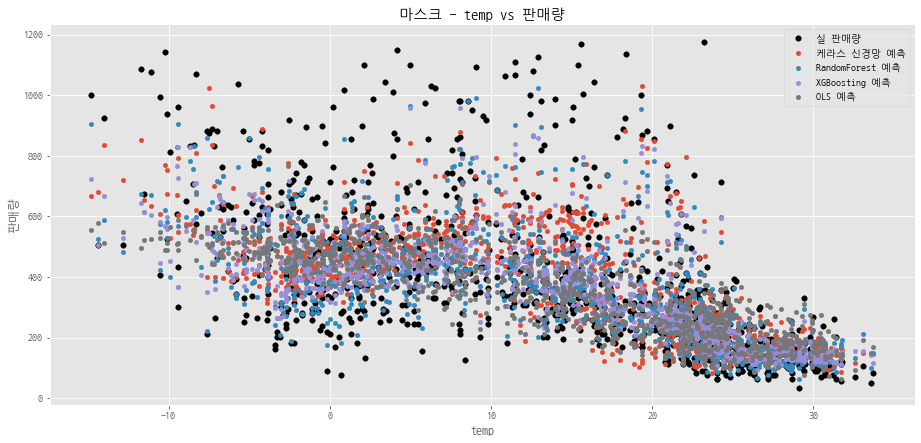

In [73]:
# 독립변수 Xy의 col번호: 0=qty
# ['qty', 'temp', 'cloud', 'wind', 'lgt_time', 'PM10', 'rain_or_not_비o', 'snow_or_not_눈o']
n=1
# alpha 값 0~1
alp = 1
# scatter plot 점 크기
dot_size = 20

matplotlib.rcParams['font.family'] = 'NanumGothicCoding'
plt.figure(figsize=(15.5,7))
plt.style.use('ggplot')
plt.title('%s - %s vs 판매량' % (item, Xy.columns[n]) )
plt.scatter(Xy.iloc[:,n],result_df.qty, label = '실 판매량', s=30, c='k', alpha = 1)
plt.scatter(Xy.iloc[:,n],result_df.keras_qty, label = '케라스 신경망 예측', alpha=alp, s=dot_size)
plt.scatter(Xy.iloc[:,n],result_df.rf_qty, label = 'RandomForest 예측', alpha=alp, s=dot_size)
plt.scatter(Xy.iloc[:,n],result_df.xgb_qty, label = 'XGBoosting 예측', alpha=alp, s=dot_size)
# plt.scatter(Xy.iloc[:,n],result_df.lin_qty, label = '선형 예측', alpha=alp, s=dot_size)
# plt.scatter(Xy.iloc[:,n],result_df.ridge_qty, label = 'Ridge 예측', alpha=alp, s=dot_size)
plt.scatter(Xy.iloc[:,n],result_df.ols_qty, label = 'OLS 예측', alpha=alp, s=dot_size)

# X axis
plt.xlabel('{}'.format(Xy.columns[n]))

# y axis
plt.ylabel('판매량')

# 범례
plt.legend()
plt.show()

## 실험 구간

In [ ]:

# 2016~2017 : 훈련 / 2018 검증 2:1
trainXy = gs_week_w.loc[:cut_line]
testXy = gs_week_w.loc[cut_line:]
train_X =pd.DataFrame(trainXy.loc[:,'temp'])
train_y = trainXy.loc[:,'qty']
val_X = pd.DataFrame(testXy.loc[:,'temp'])
val_y = testXy.loc[:,'qty']



print('여기서 점수란 R-square값을 의미한다.')
# RandomForest 회귀분석
RFmodel = RandomForestRegressor()
RFmodel.fit(train_X,train_y)
# Get the mean absolute error on the validation data
RFpredicted = RFmodel.predict(val_X)
MAE = mean_absolute_error(val_y , RFpredicted)
print('Random forest을 이용한 %s의 회귀분석 결과 :'%item)
# print('Random forest validation MAE = ', MAE)
print('훈련세트점수 : {:.3f}'.format(RFmodel.score(train_X, train_y)))
print('검증세트점수 : {:.3f}'.format(RFmodel.score(val_X, val_y)))

# XGBRegressor 회귀분석
XGBModel = XGBRegressor(objective='reg:squarederror')
XGBModel.fit(train_X,train_y , verbose=False)
# Get the mean absolute error on the validation data :
XGBpredictions = XGBModel.predict(val_X)
MAE = mean_absolute_error(val_y , XGBpredictions)
print('XGBoost을 이용한 %s의 회귀분석 결과 :'%item)
# print('XGBoost validation MAE = ',MAE)
print('훈련세트점수 : {:.3f}'.format(XGBModel.score(train_X, train_y)))
print('검증세트점수 : {:.3f}'.format(XGBModel.score(val_X, val_y)))

linReg = LinearRegression().fit(train_X, train_y)
print('LinearRegression을 이용한 %s의 회귀분석 결과 :'%item)
print('훈련세트점수 : {:.3f}'.format(linReg.score(train_X, train_y)))
print('검증세트점수 : {:.3f}'.format(linReg.score(val_X, val_y)))

ridge = Ridge(alpha=0.1, normalize=True, random_state=0, tol=0.001).fit(train_X, train_y)
print('RidgeRegression을 이용한 %s의 회귀분석 결과 :'%item)
print('훈련세트점수 : {:.3f}'.format(ridge.score(train_X, train_y)))
print('검증세트점수 : {:.3f}'.format(ridge.score(val_X, val_y)))

lasso = Lasso(alpha=0.1, max_iter=1000).fit(train_X, train_y)
print('LassoRegression을 이용한 %s의 회귀분석 결과 :'%item)
print('훈련세트점수 : {:.3f}'.format(lasso.score(train_X, train_y)) )
print('검증세트점수 : {:.3f}'.format(lasso.score(val_X, val_y)) )

customF = formulaGen(target='qty',ind_features=['temp'])
olsModel = sm.OLS.from_formula(customF, data=trainXy).fit()
print('OLS을 이용한 %s의 회귀분석 결과 :'%item)
print('훈련세트점수 : {:.3f}'.format(olsModel.rsquared) )

combined = pd.DataFrame(gs_week_w.loc[:,'temp'])
target = gs_week_w.loc[:,'qty']

# 가장 좋다고 판명된 설정을 이용하여, 예측qty생산
# predictions = NN_model.predict(combined)
# RandomForest 회귀분석 예측 qty생산
RFpredicted = RFmodel.predict(combined)
# XGBRegressor 회귀분석 예측 qty생산
XGBpredictions = XGBModel.predict(combined)
# linearRegression 회귀분석 예측 qty생산
linPred = linReg.predict(combined)
# Ridge 회귀분석 예측 qty생산
ridPred = ridge.predict(combined)
# Lasso 회귀분석 예측 qty생산
lassoPred = lasso.predict(combined)
# OLS 회귀분석 예측 qty생산
olsPred = olsModel.predict(combined)

result_df = pd.DataFrame()
result_df['week'] = gs_week_w['week']
result_df['qty'] = gs_week_w.loc[:,'qty']

# print("keras 신경망 predictions",predictions.shape)
# result_df['keras_qty'] = predictions

# print("randomforest 예상",RFpredicted.shape)
result_df['rf_qty'] = RFpredicted

# print("XGBpredictions",XGBpredictions.shape)
result_df['xgb_qty'] = XGBpredictions

# print("linearRegression 예상",RFpredicted.shape)
result_df['lin_qty'] = linPred

# print("Ridge 예상",RFpredicted.shape)
result_df['ridge_qty'] = ridPred

# print("Lasso 예상",RFpredicted.shape)
result_df['lasso_qty'] = lassoPred

# print("OLS 예상",RFpredicted.shape)
result_df['ols_qty'] = olsPred

# ============================================

In [ ]:
df_graph = result_df.loc[:,['week','qty','keras_qty','rf_qty','xgb_qty','lin_qty','ridge_qty','lasso_qty','ols_qty']]
for_visual_col = ['week','temp','cloud','wind','lgt_time','snow','rain','PM10']
df = pd.merge(df_graph, gs_week_w[for_visual_col], on='week', how='left')
# df.head(1)

In [ ]:
# 2016, 온도
# df_graph = df.loc[df.week <= 53]
# plt.figure(figsize=(15.5, 10))
# plt.scatter(df_graph.temp,df_graph.qty, ls='-', label='실제', color='green', alpha=0.5, lw=8)
# plt.scatter(df_graph.temp,df_graph.keras_qty, ls='-', label='keras예측', color='r')
# plt.scatter(df_graph.temp,df_graph.rf_qty, ls='-', label='rf예측', color='cyan')
# plt.scatter(df_graph.temp,df_graph.xgb_qty, ls='-', label='xgb예측', color='b')
# plt.scatter(df_graph.temp,df_graph.lin_qty, ls='-', label='linear예측')
# plt.scatter(df_graph.temp,df_graph.ridge_qty, ls='-', label='ridge예측')
# plt.scatter(df_graph.temp,df_graph.lasso_qty, ls='-', label='lasso예측',color='yellow')
# plt.scatter(df_graph.temp,df_graph.ols_qty, ls='-', label='ols예측', color='violet')
# plt.legend()
# plt.title('{}년도 {} 판매량 실제/예측'.format( '2016',item ))
# plt.show()

In [ ]:
qty_columns = list(df_graph.columns)[1:9]
weather_columns = list(df_graph.columns)[9:]
print(qty_columns)
print(weather_columns)

In [ ]:
x_temp = pd.DataFrame()
# x_temp['temp'] = list(range(-10,35,1))
x_temp['temp'] = np.arange(-9,35,0.5)
combined = x_temp
# RandomForest 회귀분석 예측 qty생산
RFpredicted = RFmodel.predict(combined)
# XGBRegressor 회귀분석 예측 qty생산
XGBpredictions = XGBModel.predict(combined)
# linearRegression 회귀분석 예측 qty생산
linPred = linReg.predict(combined)
# Ridge 회귀분석 예측 qty생산
ridPred = ridge.predict(combined)
# Lasso 회귀분석 예측 qty생산
lassoPred = lasso.predict(combined)
# OLS 회귀분석 예측 qty생산
olsPred = olsModel.predict(combined)

# 2016~2018, 일조시간
df_graph = df.copy()
plt.figure(figsize=(15.5, 10))
plt.scatter(df_graph[weather_columns[0]],df_graph['qty'], ls='-', color='k',label='실 판매량', s=100, alpha=0.7)
plt.plot(x_temp, RFpredicted, label = 'rf')
plt.plot(x_temp, XGBpredictions, label = 'xgb')
plt.plot(x_temp, linPred, label = 'line')
plt.plot(x_temp, ridPred, label = 'ridge')
plt.plot(x_temp, lassoPred, label = 'lasso')
plt.plot(x_temp, olsPred, label = 'ols')
plt.plot()
plt.legend()
plt.title('{}년도 {} 판매량 실제/예측'.format( '2016~2018',item ))
plt.xlabel(weather_columns[0])
plt.ylabel('판매량 (단위 : 1개)')
plt.show()

# 실험

In [ ]:
intercept_lin = linReg.intercept_
coef_line = linReg.coef_
# list_col
linePredict = list()
x_temp = list(range(-10,38,1))
for temperature in x_temp:
    linePredict.append(intercept_lin + coef_line[0]*temperature)

    
# 2016~2018, 일조시간
df_graph = df.copy()
plt.figure(figsize=(15.5, 10))
plt.scatter(df_graph[weather_columns[0]],df_graph['qty'], ls='-', color='k',label='실 판매량', s=100, alpha=0.3)
# for q_name in qty_columns:
#     plt.plot(df_graph[weather_columns[0]],df_graph[q_name], ls='-', label=q_name)
#     plt.scatter(df_graph.lgt_time,df_graph[q_name], ls='-', label='실제', color='green', alpha=0.5, lw=8)
#     plt.scatter(df_graph.lgt_time,df_graph.keras_qty, ls='-', label='keras예측', color='r')
#     plt.scatter(df_graph.lgt_time,df_graph.rf_qty, ls='-', label='rf예측', color='cyan')
#     plt.scatter(df_graph.lgt_time,df_graph.xgb_qty, ls='-', label='xgb예측', color='b')
#     plt.scatter(df_graph.lgt_time,df_graph.lin_qty, ls='-', label='linear예측')
#     plt.scatter(df_graph.lgt_time,df_graph.ridge_qty, ls='-', label='ridge예측')
#     plt.scatter(df_graph.lgt_time,df_graph.lasso_qty, ls='-', label='lasso예측',color='yellow')
#     plt.scatter(df_graph.lgt_time,df_graph.ols_qty, ls='-', label='ols예측', color='violet')
plt.plot(x_temp, linePredict, 'r--', label='linear회귀, 온도만')

plt.legend()
plt.title('{}년도 {} 판매량 실제/예측'.format( '2016~2018',item ))
plt.xlabel(weather_columns[0])
plt.ylabel('판매량 (단위 : 1개)')
plt.show()

# 시간의 경과에 따른 예측량 비교

In [ ]:
# 2016
df_graph = result_df.loc[result_df.week <=53]
plt.figure(figsize=(15.5, 10))
plt.plot(df_graph.week,df_graph.qty, ls='-', label='실제', color='green', alpha=0.5, lw=8)
plt.plot(df_graph.week,df_graph.keras_qty, ls='-', label='keras예측', color='r')
plt.plot(df_graph.week,df_graph.rf_qty, ls='-', label='rf예측', color='cyan')
plt.plot(df_graph.week,df_graph.xgb_qty, ls='-', label='xgb예측', color='b')
plt.plot(df_graph.week,df_graph.lin_qty, ls='-', label='linear예측')
plt.plot(df_graph.week,df_graph.ridge_qty, ls='-', label='ridge예측')
plt.plot(df_graph.week,df_graph.lasso_qty, ls='-', label='lasso예측',color='yellow')
plt.plot(df_graph.week,df_graph.ols_qty, ls='-', label='ols예측', color='violet')
plt.legend()
plt.title('{}년도 {} 판매량 실제/예측'.format( '2016',item ))
plt.show()

In [ ]:
# 2017
df_graph = result_df.loc[(result_df.week >=53)&(result_df.week <=105)]
plt.figure(figsize=(15.5, 10))
plt.plot(df_graph.week,df_graph.qty, ls='-', label='실제', color='green', alpha=0.5, lw=8)
plt.plot(df_graph.week,df_graph.keras_qty, ls='-', label='keras예측', color='r')
plt.plot(df_graph.week,df_graph.rf_qty, ls='-', label='rf예측', color='cyan')
plt.plot(df_graph.week,df_graph.xgb_qty, ls='-', label='xgb예측', color='b')
plt.plot(df_graph.week,df_graph.lin_qty, ls='-', label='linear예측')
plt.plot(df_graph.week,df_graph.ridge_qty, ls='-', label='ridge예측')
plt.plot(df_graph.week,df_graph.lasso_qty, ls='-', label='lasso예측',color='yellow')
plt.plot(df_graph.week,df_graph.ols_qty, ls='-', label='ols예측', color='violet')
plt.title('{}년도 {} 판매량 실제/예측'.format( '2017',item ))
plt.legend()
plt.show()

In [ ]:
# 2018
df_graph = result_df.loc[(result_df.week >=105)]
plt.figure(figsize=(15.5, 10))
plt.plot(df_graph.week,df_graph.qty, ls='-', label='실제', color='green', alpha=0.5, lw=8)
plt.plot(df_graph.week,df_graph.keras_qty, ls='-', label='keras예측', color='r')
plt.plot(df_graph.week,df_graph.rf_qty, ls='-', label='rf예측', color='cyan')
plt.plot(df_graph.week,df_graph.xgb_qty, ls='-', label='xgb예측', color='b')
plt.plot(df_graph.week,df_graph.lin_qty, ls='-', label='linear예측')
plt.plot(df_graph.week,df_graph.ridge_qty, ls='-', label='ridge예측')
plt.plot(df_graph.week,df_graph.lasso_qty, ls='-', label='lasso예측',color='yellow')
plt.plot(df_graph.week,df_graph.ols_qty, ls='-', label='ols예측', color='violet')
plt.title('{}년도 {} 판매량 실제/예측'.format( '2018',item ))
plt.legend()
plt.show()

In [ ]:
# 2016~2018
plt.figure(figsize=(15.5, 10))
plt.plot(result_df.week,result_df.qty, ls='-', label='실제', color='green', alpha=0.5, lw=8)
plt.plot(result_df.week,result_df.keras_qty, ls='-', label='keras예측', color='r')
plt.plot(result_df.week,result_df.rf_qty, ls='-', label='rf예측', color='cyan')
plt.plot(result_df.week,result_df.xgb_qty, ls='-', label='xgb예측', color='b')
plt.plot(df_graph.week,df_graph.lin_qty, ls='-', label='linear예측')
plt.plot(df_graph.week,df_graph.ridge_qty, ls='-', label='ridge예측')
plt.plot(df_graph.week,df_graph.lasso_qty, ls='-', label='lasso예측',color='yellow')
plt.plot(df_graph.week,df_graph.ols_qty, ls='-', label='ols예측', color='violet')
plt.title('{}년도 {} 판매량 실제/예측'.format( '2016~2018',item ))
plt.legend()
plt.show()

In [ ]:
def r2_score(v_true, v_pred):
    ssr = np.sum(np.square(v_pred - np.mean(v_true)))
    sst = np.sum(np.square(v_true - np.mean(v_true)))
    return ( ssr / sst)

In [ ]:
checked_for = '2016~2017'
combined = aaaaa.loc[:106,'temp':'PM10']
target = aaaaa.loc[:106,'qty']

# 가장 좋다고 판명된 설정을 이용하여, 예측qty생산
predictions = NN_model.predict(combined)
# RandomForest 회귀분석 예측 qty생산
RFpredicted = RFmodel.predict(combined)
# XGBRegressor 회귀분석 예측 qty생산
XGBpredictions = XGBModel.predict(combined)
# linearRegression 회귀분석 예측 qty생산
linPred = linReg.predict(combined)
# Ridge 회귀분석 예측 qty생산
ridPred = ridge.predict(combined)
# Lasso 회귀분석 예측 qty생산
lassoPred = lasso.predict(combined)
# OLS 회귀분석 예측 qty생산
olsPred = olsModel.predict(combined)
qty = target

print(checked_for)
print('RF R2값  \t: ','{:<.5f}'.format(r2_score(qty, RFpredicted)) )
print('XGB R2값  \t: ','{:<.5f}'.format(r2_score(qty, XGBpredictions)) )
print('KerasNN R2값\t: ','{:<.5f}'.format(r2_score(qty,predictions )) )
print('LinReg R2값\t: ','{:<.5f}'.format(r2_score(qty, linPred)) )
print('Ridge R2값  \t: ','{:<.5f}'.format(r2_score(qty, ridPred)) )
print('Lasso R2값\t: ','{:<.5f}'.format(r2_score(qty, lassoPred )) )
print('OLS R2값\t: ','{:<.5f}'.format(r2_score(qty, olsPred )) )

In [ ]:
checked_for = '2018'
combined = aaaaa.loc[106:,'temp':'PM10']
target = aaaaa.loc[106:,'qty']

# 가장 좋다고 판명된 설정을 이용하여, 예측qty생산
predictions = NN_model.predict(combined)
# RandomForest 회귀분석 예측 qty생산
RFpredicted = RFmodel.predict(combined)
# XGBRegressor 회귀분석 예측 qty생산
XGBpredictions = XGBModel.predict(combined)
# linearRegression 회귀분석 예측 qty생산
linPred = linReg.predict(combined)
# Ridge 회귀분석 예측 qty생산
ridPred = ridge.predict(combined)
# Lasso 회귀분석 예측 qty생산
lassoPred = lasso.predict(combined)
# OLS 회귀분석 예측 qty생산
olsPred = olsModel.predict(combined)

qty = target

print(checked_for)
print('RF R2값  \t: ','{:<.5f}'.format(r2_score(qty, RFpredicted)) )
print('XGB R2값  \t: ','{:<.5f}'.format(r2_score(qty, XGBpredictions)) )
print('KerasNN R2값\t: ','{:<.5f}'.format(r2_score(qty,predictions )) )
print('LinReg R2값\t: ','{:<.5f}'.format(r2_score(qty, linPred)) )
print('Ridge R2값  \t: ','{:<.5f}'.format(r2_score(qty, ridPred)) )
print('Lasso R2값\t: ','{:<.5f}'.format(r2_score(qty, lassoPred )) )
print('OLS R2값\t: ','{:<.5f}'.format(r2_score(qty, olsPred )) )

In [ ]:
checked_for = '2016~2018'
combined = aaaaa.loc[:,'temp':'PM10']
target = aaaaa.loc[:,'qty']

# 가장 좋다고 판명된 설정을 이용하여, 예측qty생산
predictions = NN_model.predict(combined)
# RandomForest 회귀분석 예측 qty생산
RFpredicted = RFmodel.predict(combined)
# XGBRegressor 회귀분석 예측 qty생산
XGBpredictions = XGBModel.predict(combined)
# linearRegression 회귀분석 예측 qty생산
linPred = linReg.predict(combined)
# Ridge 회귀분석 예측 qty생산
ridPred = ridge.predict(combined)
# Lasso 회귀분석 예측 qty생산
lassoPred = lasso.predict(combined)
# OLS 회귀분석 예측 qty생산
olsPred = olsModel.predict(combined)

qty = target

print(checked_for)
print('RF R2값  \t: ','{:<.5f}'.format(r2_score(qty, RFpredicted)) )
print('XGB R2값  \t: ','{:<.5f}'.format(r2_score(qty, XGBpredictions)) )
print('KerasNN R2값\t: ','{:<.5f}'.format(r2_score(qty,predictions )) )
print('LinReg R2값\t: ','{:<.5f}'.format(r2_score(qty, linPred)) )
print('Ridge R2값  \t: ','{:<.5f}'.format(r2_score(qty, ridPred)) )
print('Lasso R2값\t: ','{:<.5f}'.format(r2_score(qty, lassoPred )) )
print('OLS R2값\t: ','{:<.5f}'.format(r2_score(qty, olsPred )) )

In [ ]:
path = 'D:/project/contest/data/result/'
result_df.to_csv(path+item+'_'+grouped_by+'_predict(lowVIF07).csv', encoding='utf-8', index=False)

In [ ]:
# 날씨+sns와 아이스크림 을 사용하면 2017까진 적당하고 2018년도는 예측율 급락
#  -> 과적합화 발생
# 날씨와 아이스크림 판매량만 이용하니 ㅇㅋ